## Convert the images to arrays

And serialize them as bcolz

In [1]:
%load_ext autoreload
%autoreload 2

In [52]:
from utils import *

import os
import glob
import random
import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from skimage.transform import resize
from tensorflow.keras.preprocessing import image as image_utils

In [3]:
train_path = "data/train/images/"
train_masks_path = "data/train/masks/"
test_path = "data/test/images"

Sort them so we know the order

In [4]:
train_files = sorted(glob.glob(os.path.join(train_path, "*.png")))
masks_files = sorted(glob.glob(os.path.join(train_masks_path, "*.png")))
test_files = sorted(glob.glob(os.path.join(test_path, "*.png")))

In [5]:
assert len(train_files) == len(masks_files)

In [6]:
train_ids = []
x_train = np.zeros((len(train_files), OR_IM_HEIGHT, OR_IM_WIDTH, 3), dtype=np.uint8)
y_train = np.zeros((len(masks_files), OR_IM_HEIGHT, OR_IM_WIDTH, 3), dtype=np.uint8)

In [7]:
x_train.shape, y_train.shape

((4000, 101, 101, 3), (4000, 101, 101, 3))

In [8]:
for i, (train_path, mask_path) in tqdm.tqdm_notebook(enumerate(zip(train_files, masks_files)), total=len(train_files)):
    train_id = os.path.basename(train_path)[:-4]
    mask_id = os.path.basename(mask_path)[:-4]
    assert train_id == mask_id
    train_ids.append(train_id)
    
    x = image_utils.img_to_array(image_utils.load_img(train_path, grayscale=True))
    x_train[i] = x

    y = image_utils.img_to_array(image_utils.load_img(mask_path, grayscale=True))
    y_train[i] = y

In [9]:
len(train_ids)

4000

## Sanity check

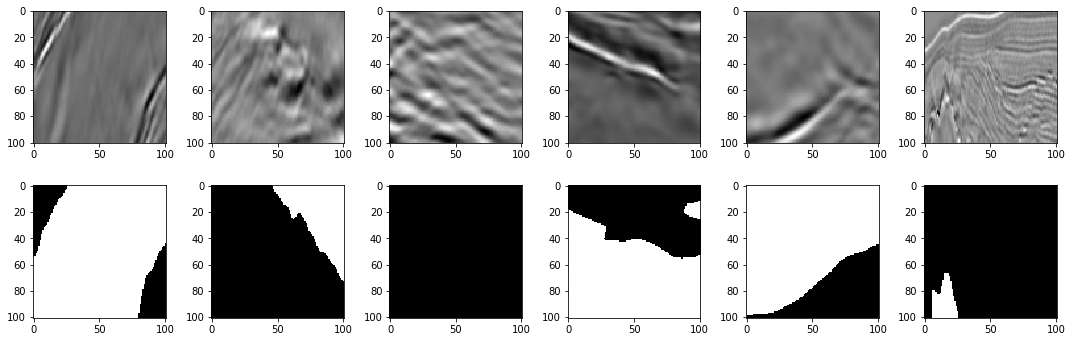

In [10]:
n_images = 6
fig, axarr = plt.subplots(2, n_images, figsize=(15, 5))
for image in range(n_images):
    n = random.randint(1, x_train.shape[0])
    axarr[0, image].imshow(x_train[n])
    axarr[1, image].imshow(y_train[n])
fig.tight_layout()

## Test data

In [11]:
test_ids = []
x_test = np.zeros((len(test_files), OR_IM_HEIGHT, OR_IM_WIDTH, OR_IM_CHANNEL), dtype=np.uint8)

for i, test_path in tqdm.tqdm_notebook(enumerate(test_files), total=len(test_files)):
    test_id = os.path.basename(test_path)[:-4]
    test_ids.append(test_id)
    
    x = image_utils.img_to_array(image_utils.load_img(test_path, grayscale=True))
    x_test[i] = x

In [12]:
x_test.shape

(18000, 101, 101, 3)

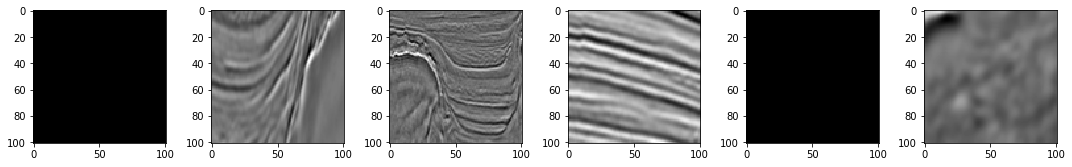

In [13]:
n_images = 6
fig, axarr = plt.subplots(1, n_images, figsize=(15, 5))
for image in range(n_images):
    n = random.randint(1, x_test.shape[0])
    axarr[image].imshow(x_test[n])
fig.tight_layout()

## Stratify training data

We measure how much salt (mask) is on each photo and we divide this in n groups.

Since the mask is just black and white we can just sum each pixel (black=1) of the mask and divide by the size of the img

In [14]:
coverage_train = np.zeros((x_train.shape[0], ), dtype=np.float64)

In [15]:
for i, (image, mask) in tqdm.tqdm_notebook(enumerate(zip(x_train, y_train)), total=x_train.shape[0]):
    coverage_train[i] = np.mean(mask) / 255

In [16]:
coverage_train

array([0.        , 0.03293795, 0.        , ..., 0.        , 0.08685423,
       0.70453877])

In [17]:
strata_train = np.zeros((x_train.shape[0], ), dtype=np.uint8)

In [18]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
v_cov_to_class = np.vectorize(cov_to_class)
strata_train = v_cov_to_class(coverage_train)

In [19]:
strata_train

array([0, 1, 0, ..., 0, 1, 8])

/home/ubuntu/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Coverage class')

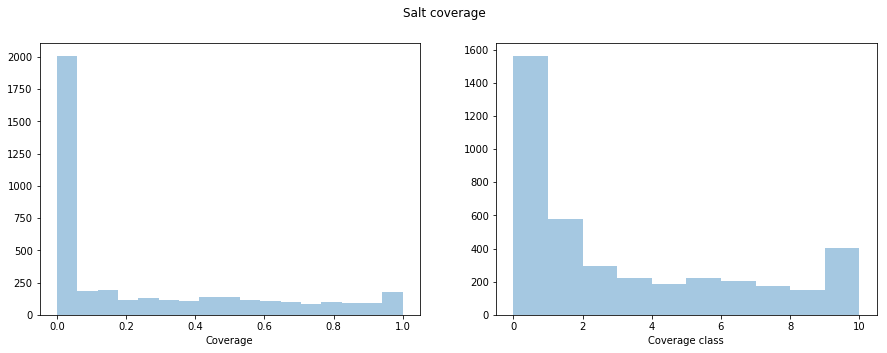

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(coverage_train, kde=False, ax=axs[0])
sns.distplot(strata_train, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

## Sanity check for the strata

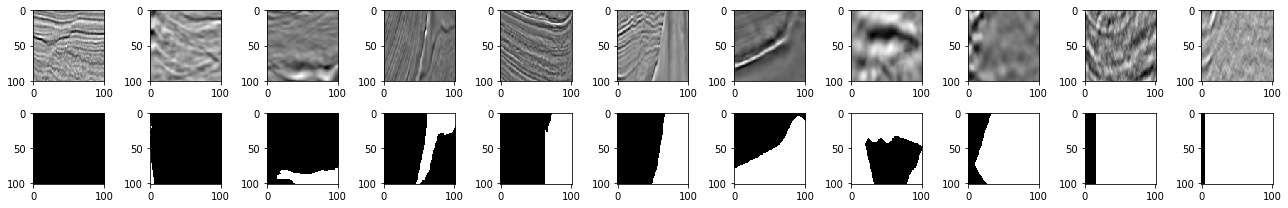

In [21]:
n_images = 11
fig, axarr = plt.subplots(2, n_images, figsize=(18, 3))
for image in range(n_images):
    statum_img = x_train[strata_train == image]
    statum_mask = y_train[strata_train == image]
    n = random.randint(1, statum_img.shape[0])
    axarr[0, image].imshow(statum_img[n])
    axarr[1, image].imshow(statum_mask[n])
fig.tight_layout()

## Save arrays

In [41]:
save_arr("data/train_ids.arr", train_ids)

In [53]:
v_upsample = np.vectorize(upsample)

In [54]:
x_train_up = np.array([upsample(img) for img in tqdm.tqdm_notebook(x_train, total=x_train.shape[0])])

In [55]:
x_train_up.shape

(4000, 128, 128, 1)

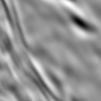

In [63]:
image_utils.array_to_img(x_train[50])

In [56]:
save_arr("data/x_train.arr", x_train_up)

In [57]:
from skimage.transform import resize

In [58]:
y_train_up = np.array([upsample(img) for img in tqdm.tqdm_notebook(y_train, total=y_train.shape[0])])

In [59]:
y_train_up.shape

(4000, 128, 128, 1)

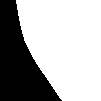

In [62]:
image_utils.array_to_img(y_train[50])

In [64]:
save_arr("data/y_train.arr", y_train_up)

In [70]:
save_arr("data/strata_train.arr", strata_train)

In [65]:
save_arr("data/test_ids.arr", test_ids)

In [66]:
x_test_up = np.array([upsample(img) for img in tqdm.tqdm_notebook(x_test, total=x_test.shape[0])])

In [67]:
x_test_up.shape

(18000, 128, 128, 1)

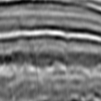

In [68]:
image_utils.array_to_img(x_test[50])

In [69]:
save_arr("data/x_test.arr", x_test)